In [ ]:
#目标检测 Object Detection



In [391]:
import tensorflow as tf
import keras.backend as K

In [392]:
print(tf.__version__)

2.15.0


In [393]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    ### START CODE HERE ### (≈ 1 line)
    box_scores = box_confidence*box_class_probs
    ### END CODE HERE ###

    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = tf.math.argmax(box_scores, axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1)
    ### END CODE HERE ###

    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    filtering_mask = box_class_scores >= threshold  # don't use A.eval() >= B
    ### END CODE HERE ###

    # Step 4: Apply the mask to scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [394]:
with tf.compat.v1.Session() as test_a:
    box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


In [395]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ### START CODE HERE ### (≈ 5 lines)
    xi1 = max(box1[0],box2[0])   # 左上角谁更大，谁就是交集的左上角
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])   # 右下角谁更小，谁就是交集的右下角
    yi2 = min(box1[3],box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
    ### END CODE HERE ###    

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ### (≈ 3 lines)
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])  # 并集就是两个面积和减去交集面积
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area
    ### END CODE HERE ###

    # compute the IoU
    ### START CODE HERE ### (≈ 1 line)
    iou = inter_area / union_area
    ### END CODE HERE ###
    return iou


In [396]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


In [397]:
# GRADED FUNCTION: yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
#     max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
#     tf.compat.v1.keras.backend.get_session().run(tf.compat.v1.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    ### END CODE HERE ###

    # Use K.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.compat.v1.keras.backend.gather(scores, nms_indices)
    boxes =  tf.compat.v1.keras.backend.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [398]:
with tf.compat.v1.Session() as test_b:
    scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes=9, iou_threshold=0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores.shape = (54,)
boxes.shape = (54, 4)
classes.shape = (54,)
scores[2] = 7.119767
boxes[2] = [-4.0407705  1.7758924  7.287429  -0.5516968]
classes[2] = 2.773162
scores.shape = (9,)
boxes.shape = (9, 4)
classes.shape = (9,)


In [399]:
def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


# GRADED FUNCTION: yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
 ### START CODE HERE ### 

    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs[:]

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)

    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    ### END CODE HERE ###
    
    return scores, boxes, classes

In [400]:
with tf.compat.v1.Session() as test_b:
    yolo_outputs = (tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [401]:
import numpy as np

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors


class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

In [402]:
print(anchors[0])

[0.57273  0.677385]


In [403]:
from keras.models import load_model, Model

yolo_model = load_model("model_data/yolo.h5")

/home/yihang/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(
/home/yihang/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/lambda_layer.py:331: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  output_shape = cls._parse_function_from_config(


Instructions for updating:
Colocations handled automatically by placer.


2024-03-06 10:39:27.302764: W tensorflow/c/c_api.cc:305] Operation '{name:'batch_normalization_16/moving_mean/Assign' id:3769 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_16/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_16/moving_mean, batch_normalization_16/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [404]:
sess = tf.compat.v1.keras.backend.get_session()

In [405]:
yolo_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 608, 608, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 608, 608, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 608, 608, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 608, 608, 32)         0         ['batch_normalization[0][0

 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)   (None, 38, 38, 512)          0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 38, 38, 256)          131072    ['leaky_re_lu_8[0][0]']       
                                                                                                  
 batch_normalization_9 (Bat  (None, 38, 38, 256)          1024      ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_

 tchNormalization)                                                                                
                                                                                                  
 conv2d_20 (Conv2D)          (None, 38, 38, 64)           32768     ['leaky_re_lu_12[0][0]']      
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)  (None, 19, 19, 1024)         0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_20 (Ba  (None, 38, 38, 64)           256       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_19

In [406]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)

In [407]:
print(class_names[0])
print(image_shape[0])

person
720.0


In [408]:


def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.

    Parameters
    ----------
    feats : tensor
        Final convolutional layer features.
    anchors : array-like
        Anchor box widths and heights.
    num_classes : int
        Number of target classes.

    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])
    # Static implementation for fixed models.
    # TODO: Remove or add option for static implementation.
    # _, conv_height, conv_width, _ = K.int_shape(feats)
    # conv_dims = K.variable([conv_width, conv_height])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))
    
    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    # Static generation of conv_index:
    # conv_index = np.array([_ for _ in np.ndindex(conv_width, conv_height)])
    # conv_index = conv_index[:, [1, 0]]  # swap columns for YOLO ordering.
    # conv_index = K.variable(
    #     conv_index.reshape(1, conv_height, conv_width, 1, 2))
    # feats = Reshape(
    #     (conv_dims[0], conv_dims[1], num_anchors, num_classes + 5))(feats)

    box_confidence = K.sigmoid(feats[..., 4:5])
    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_confidence, box_xy, box_wh, box_class_probs


yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [409]:
print(yolo_outputs)

(<tf.Tensor 'Sigmoid:0' shape=(?, ?, ?, 5, 1) dtype=float32>, <tf.Tensor 'truediv_8:0' shape=(?, ?, ?, 5, 2) dtype=float32>, <tf.Tensor 'truediv_9:0' shape=(?, ?, ?, 5, 2) dtype=float32>, <tf.Tensor 'Softmax:0' shape=(?, ?, ?, 5, 80) dtype=float32>)


In [410]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [411]:
import imghdr
from PIL import Image, ImageDraw, ImageFont

def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

image_file = "0021.jpg"
image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

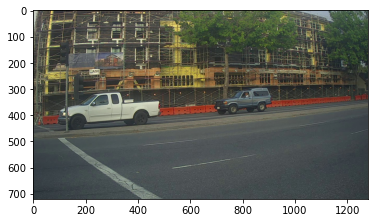

In [412]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [363]:
def predict(model, image_file):  
  

    image, image_data = yolo_utils.preprocess_image("images/" + image_file, model_image_size=(608, 608))  

    predictions = model.predict(image_data) 

    print(predictions.shape)
    
    indices_to_extract = slice(0, 425, 85)  
    out_scores = predictions[:, :, :, indices_to_extract]  
    print(out_scores.shape)
    
    # 首先，取最后一维的第1、2、3、4个元素  
    
#     # 接下来，每隔81个取4个元素  
#     # 计算初始索引之后的起始索引  
#     start_index = 90  # 因为我们已经取了前4个元素  
#     end_index = 425  # 最后一维的总长度  
#     step_size = 85   # 每隔81个取一个  
#     num_elements = 4 # 每次取4个元素  

#     # 计算可以取的片段数量  
#     num_slices = (end_index - start_index) // step_size + 1
   
#     print(num_slices)

    first_few_elements = predictions[:, :, :, [1, 2, 3, 4]]
    # 提取这些元素  
    additional_elements = []  
    start_index = 86
    step_size = 85
    num_elements = 4
    for i in range(5):
        slice_start = start_index + i * step_size  
        slice_end = slice_start + num_elements       
        additional_elements.append(predictions[:, :, :, slice_start:slice_end])  

    

    # 将所有提取的元素合并在一起  
    out_boxes = np.concatenate([first_few_elements] + additional_elements, axis=-1)  
    print(out_boxes.shape)

    
    first_few_elements = predictions[:, :, :, [1, 2, 3, 4]]
    # 提取这些元素  
    additional_elements = []  
    start_index = 5
    step_size = 85
    num_elements = 80
    for i in range(5):
        slice_start = start_index + i * step_size  
        slice_end = slice_start + num_elements  
        print(slice_start)
        print(slice_end)
        additional_elements.append(predictions[:, :, :, slice_start:slice_end])  
        print(len(additional_elements))
    

    # 将所有提取的元素合并在一起  
    out_classes = np.concatenate(additional_elements, axis=-1)  
    print(out_classes.shape)

    return out_scores, out_boxes, out_classes  


In [458]:
# import tensorflow._api.v2.compat.v1 as tf
# tf.disable_v2_behavior()

def yolo_eval(yolo_outputs,
              image_shape,
              max_boxes=10,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input batch and return filtered boxes."""
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    boxes, scores, classes = yolo_filter_boxes(
        box_confidence, boxes, box_class_probs, threshold=score_threshold)
    
    # Scale boxes back to original image shape.
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims

    # TODO: Something must be done about this ugly hack!
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_index = tf.image.non_max_suppression(
        boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, nms_index)
    scores = K.gather(scores, nms_index)
    classes = K.gather(classes, nms_index)
    
    return boxes, scores, classes

def predict_ng(model, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    # 运行会话并在feed_dict中选择正确的占位符
#     out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={ yolo_model.input: image_data, K.learning_phase(): 0})
#     out_scores= sess.run(tf.convert_to_tensor(image_data))
#     print(out_scores.shape)
    
    predictions = model.predict(image_data)
    print(predictions.shape)
    
    # 置信度
    indices_to_extract = slice(0, 425, 85)  
    box_confidence = predictions[:, :, :, indices_to_extract]  
    print("confidence" + str(box_confidence.shape))

    # xy
    first_few_elements = predictions[:, :, :, [1, 2]]
    additional_elements = []  
    start_index = 86
    step_size = 85
    num_elements = 2
    for i in range(4):
        slice_start = start_index + i * step_size  
        slice_end = slice_start + num_elements
        print(slice_start)
        print(slice_end)
        additional_elements.append(predictions[:, :, :, slice_start:slice_end])  

    # 将所有提取的元素合并在一起  
    box_xy = np.concatenate([first_few_elements] + additional_elements, axis=-1)  
    print("xy:" + str(box_xy.shape))
    
    # wh
    first_few_elements = predictions[:, :, :, [3, 4]]
    additional_elements = []  
    start_index = 88
    step_size = 85
    num_elements = 2
    for i in range(4):
        slice_start = start_index + i * step_size  
        slice_end = slice_start + num_elements
        print(slice_start)
        print(slice_end)
        additional_elements.append(predictions[:, :, :, slice_start:slice_end])  

    # 将所有提取的元素合并在一起  
    box_wh = np.concatenate([first_few_elements] + additional_elements, axis=-1)  
    print("wh:" + str(box_wh.shape))
    
    # 概率
    first_few_elements = predictions[:, :, :, 5:85]
    print(first_few_elements.shape)
    additional_elements = []  
    start_index = 90
    step_size = 85
    num_elements = 80
    for i in range(4):
        slice_start = start_index + i * step_size  
        slice_end = slice_start + num_elements  
        print(slice_start)
        print(slice_end)
        additional_elements.append(predictions[:, :, :, slice_start:slice_end])      

    # 将所有提取的元素合并在一起  
    box_class_probs = np.concatenate([first_few_elements]+additional_elements, axis=-1)  
    print("class:"+str(box_class_probs.shape))
    
    yolo_outputs = [box_confidence, box_xy, box_wh, box_class_probs]
    
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs[:]
    print(box_confidence.shape)
    print(box_xy.shape)
    print(box_wh.shape)
    print(box_class_probs.shape)

    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, image_shape= (720., 1280.))
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes for {}'.format(out_boxes.shape, image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

In [474]:
from PIL import Image

%matplotlib inline

def predict_fuck(sess, image_file):
    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],feed_dict={yolo_model.input: image_data,K.learning_phase(): 0})
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
#     output_image = scipy.misc.imread(os.path.join("out", image_file))
#     imshow(output_image)
    output_image = Image.open(os.path.join("out", image_file))
    plt.imshow(output_image)
    
    return out_scores, out_boxes, out_classes


Found 2 boxes for 0021.jpg
car
car0.6191161 (691, 292) (914, 403)
truck
truck0.7173047 (88, 317) (493, 450)


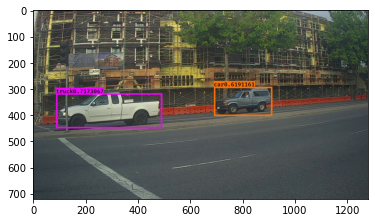

In [475]:
# out_scores, out_boxes, out_classes = predict(yolo_model, "0021.jpg")


# out_scores, out_boxes, out_classes = predict_ng(yolo_model, "0021.jpg")

out_scores, out_boxes, out_classes = predict_fuck(sess, "0021.jpg")